# 温度変化dfの前処理

## おまじないパート

In [1]:
import sys
from pathlib import Path

# 現在のノートブックのパスを取得
notebook_dir = Path().resolve() 

# プロジェクトルートディレクトリ（notebooksディレクトリの親ディレクトリ）を取得
# プロジェクトルートは2階層上です
project_root = notebook_dir.parent.parent

# プロジェクトルートをPythonの検索パスに追加
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

In [2]:
from groom import DataCleaner, save_to_parquet, save_model


In [3]:
self = DataCleaner()

In [4]:
import pandas as pd

## behaviorでのgroup分けより前必要な前処理

### 読み込み

In [5]:
raw_temperature_df = pd.read_csv(project_root / "data" / "t=0_1_1.csv")
print(raw_temperature_df.head())

     Date     time    name  id sex  facetemp nosetemp  facehigh  facelow  \
0  20-Apr  8:48:50  Takana  21   f      31.2     28.3      34.2     26.3   
1  20-Apr  8:49:00  Takana  21   f      31.8     28.4      34.6     26.5   
2  20-Apr  8:49:12  Takana  21   f      32.4     28.6      34.7     27.0   
3  20-Apr  8:49:25  Takana  21   f      32.4     28.4      35.6     27.0   
4  20-Apr  8:49:38  Takana  21   f      32.9     28.9      36.1     27.0   

  facehigh.1 facelow.1 behavior   to from shade luminocity  kin  t0_flag  
0        eye      nose       BL  NaN  NaN    no        240  NaN      1.0  
1        eye      nose       BL  NaN  NaN    no        240  NaN      NaN  
2        eye      nose       BL  NaN  NaN    no        240  NaN      NaN  
3        eye      nose       BL  NaN  NaN    no        240  NaN      NaN  
4        eye      nose       BL  NaN  NaN    no        240  NaN      NaN  


### 日時表記の整理

In [6]:
# --- 実行 ---
raw_temperature_df = self.process_datetime_columns(raw_temperature_df, year=2025)
print(raw_temperature_df.head())

             datetime    name  id sex  facetemp nosetemp  facehigh  facelow  \
0 2025-04-20 08:48:50  Takana  21   f      31.2     28.3      34.2     26.3   
1 2025-04-20 08:49:00  Takana  21   f      31.8     28.4      34.6     26.5   
2 2025-04-20 08:49:12  Takana  21   f      32.4     28.6      34.7     27.0   
3 2025-04-20 08:49:25  Takana  21   f      32.4     28.4      35.6     27.0   
4 2025-04-20 08:49:38  Takana  21   f      32.9     28.9      36.1     27.0   

  facehigh.1 facelow.1 behavior   to from shade luminocity  kin  t0_flag  
0        eye      nose       BL  NaN  NaN    no        240  NaN      1.0  
1        eye      nose       BL  NaN  NaN    no        240  NaN      NaN  
2        eye      nose       BL  NaN  NaN    no        240  NaN      NaN  
3        eye      nose       BL  NaN  NaN    no        240  NaN      NaN  
4        eye      nose       BL  NaN  NaN    no        240  NaN      NaN  


### 不要な列の削除

- "facehigh"
- "facelow" 
- "facehigh.1" 
- "facelow.1" 
- "luminocity"

In [7]:
dropped_temperature_df = self.drop_unnecessary_columns(raw_temperature_df)
print(dropped_temperature_df.head())

             datetime    name  id sex  facetemp nosetemp behavior   to from  \
0 2025-04-20 08:48:50  Takana  21   f      31.2     28.3       BL  NaN  NaN   
1 2025-04-20 08:49:00  Takana  21   f      31.8     28.4       BL  NaN  NaN   
2 2025-04-20 08:49:12  Takana  21   f      32.4     28.6       BL  NaN  NaN   
3 2025-04-20 08:49:25  Takana  21   f      32.4     28.4       BL  NaN  NaN   
4 2025-04-20 08:49:38  Takana  21   f      32.9     28.9       BL  NaN  NaN   

  shade  kin  t0_flag  
0    no  NaN      1.0  
1    no  NaN      NaN  
2    no  NaN      NaN  
3    no  NaN      NaN  
4    no  NaN      NaN  


### sample_idの付与

記録単位の切り替わり判定
- 条件1: t0_flag が 1 である
- 条件2: 前の行から個体名 (name) が変わった
- 条件3: 前の行から10分 (600秒) 以上経過している

In [8]:
labeled_temperature_df = self.add_sampling_id(dropped_temperature_df)
print(labeled_temperature_df.head(10))

   sampling_id  t0_flag            datetime    name  id sex  facetemp  \
0            1      1.0 2025-04-20 08:48:50  Takana  21   f      31.2   
1            1      NaN 2025-04-20 08:49:00  Takana  21   f      31.8   
2            1      NaN 2025-04-20 08:49:12  Takana  21   f      32.4   
3            1      NaN 2025-04-20 08:49:25  Takana  21   f      32.4   
4            1      NaN 2025-04-20 08:49:38  Takana  21   f      32.9   
5            1      NaN 2025-04-20 08:49:52  Takana  21   f      33.8   
6            1      NaN 2025-04-20 08:50:53  Takana  21   f      32.0   
7            1      NaN 2025-04-20 08:51:03  Takana  21   f      31.2   
8            1      NaN 2025-04-20 08:51:37  Takana  21   f      30.7   
9            1      NaN 2025-04-20 08:51:47  Takana  21   f      30.4   

  nosetemp behavior   to from shade  kin  
0     28.3       BL  NaN  NaN    no  NaN  
1     28.4       BL  NaN  NaN    no  NaN  
2     28.6       BL  NaN  NaN    no  NaN  
3     28.4       BL  NaN

### behavior変化・Sgの有無フラグの付与

In [9]:
behavior_flagged_temperature_df = self.add_behavior_analysis_cols(labeled_temperature_df)

In [10]:
# 153行目から159行目（160行目3を含む）を表示
print(behavior_flagged_temperature_df.iloc[153:159])

     sampling_id  t0_flag            datetime   name  id sex  facetemp  \
153           13      NaN 2025-05-11 09:57:56  Kanna   1   f      34.5   
154           13      NaN 2025-05-11 09:58:04  Kanna   1   f      34.8   
155           13      NaN 2025-05-11 09:58:13  Kanna   1   f      34.6   
156           13      NaN 2025-05-11 09:59:28  Kanna   1   f      33.4   
157           13      NaN 2025-05-11 10:00:16  Kanna   1   f      35.1   
158           13      NaN 2025-05-11 10:00:24  Kanna   1   f      35.3   

    nosetemp behavior   to  from shade  kin  is_role_swapped  has_Sg  \
153     33.3  groomed  NaN  Kobu   yes   no            False    True   
154     33.7  groomed  NaN  Kobu   yes   no            False    True   
155       33  groomed  NaN  Kobu   yes   no            False    True   
156       32       Sg  NaN   NaN    no  NaN            False    True   
157       33       Sg  NaN   NaN    no  NaN            False    True   
158       33       Sg  NaN   NaN    no  NaN      

### session内で最初のbehaviorのものをフィルタリング

`groomer` -> `groomee`などの役割交代後のデータは解析のノイズになるので使わない

`is_initial_behavior`列はdrop

行数・列数をprint

In [11]:
print(behavior_flagged_temperature_df.shape)
initial_behavior_df = self.filter_initial_behavior_only(behavior_flagged_temperature_df)
print(initial_behavior_df.shape)

(3625, 16)
(3493, 15)


In [12]:
print(initial_behavior_df.head())

   sampling_id  t0_flag            datetime    name  id sex  facetemp  \
0            1      1.0 2025-04-20 08:48:50  Takana  21   f      31.2   
1            1      NaN 2025-04-20 08:49:00  Takana  21   f      31.8   
2            1      NaN 2025-04-20 08:49:12  Takana  21   f      32.4   
3            1      NaN 2025-04-20 08:49:25  Takana  21   f      32.4   
4            1      NaN 2025-04-20 08:49:38  Takana  21   f      32.9   

  nosetemp behavior   to from shade  kin  is_role_swapped  has_Sg  
0     28.3       BL  NaN  NaN    no  NaN            False   False  
1     28.4       BL  NaN  NaN    no  NaN            False   False  
2     28.6       BL  NaN  NaN    no  NaN            False   False  
3     28.4       BL  NaN  NaN    no  NaN            False   False  
4     28.9       BL  NaN  NaN    no  NaN            False   False  


### 温度変化・時間経過列を追加

In [13]:
raw_delta_df = self.add_temperature_delta(initial_behavior_df)
print(raw_delta_df.head())

   sampling_id  t0_flag            datetime  delta_time  delta_face  \
0            1      1.0 2025-04-20 08:48:50         0.0         0.0   
1            1      NaN 2025-04-20 08:49:00        10.0         0.6   
2            1      NaN 2025-04-20 08:49:12        22.0         1.2   
3            1      NaN 2025-04-20 08:49:25        35.0         1.2   
4            1      NaN 2025-04-20 08:49:38        48.0         1.7   

   delta_nose    name  id sex behavior   to from shade  kin  is_role_swapped  \
0         0.0  Takana  21   f       BL  NaN  NaN    no  NaN            False   
1         0.1  Takana  21   f       BL  NaN  NaN    no  NaN            False   
2         0.3  Takana  21   f       BL  NaN  NaN    no  NaN            False   
3         0.1  Takana  21   f       BL  NaN  NaN    no  NaN            False   
4         0.6  Takana  21   f       BL  NaN  NaN    no  NaN            False   

   has_Sg  
0   False  
1   False  
2   False  
3   False  
4   False  


### 初期行動が`dango`および`Sg`のsampleを除去

In [14]:
# 条件に合致する行を抽出
# ※ is_role_swappedがBool型（True/False）の場合は == False
# ※ もし文字列型（'False'）の場合は == 'False' としてください
# filtered_df = delta_df[(delta_df['is_role_swapped'] == False) & (delta_df['behavior'] == 'Sg')]
sg_filtered_df = raw_delta_df[raw_delta_df['behavior'] == 'Sg']

# 特定の列だけを選択して表示
# print(filtered_df[['datetime', 'sampling_id']])

# 行数も確認したい場合
print(f"\n該当件数: {len(sg_filtered_df)}件")


該当件数: 4件


In [15]:
# 条件に合致する行を抽出
# ※ is_role_swappedがBool型（True/False）の場合は == False
# ※ もし文字列型（'False'）の場合は == 'False' としてください
# filtered_df = delta_df[(delta_df['is_role_swapped'] == False) & (delta_df['behavior'] == 'Sg')]
dango_filtered_df = raw_delta_df[raw_delta_df['behavior'] == 'dango']

# 行数も確認したい場合
print(f"\n該当件数: {len(dango_filtered_df)}件")


該当件数: 449件


In [16]:
# 'dango' と 'Sg' を含まない（除外する）行だけを抽出
cleaned_delta_df = raw_delta_df[~raw_delta_df['behavior'].isin(['dango', 'Sg'])]

# 確認のためにユニークな値を出力
print("残ったbehavior:", cleaned_delta_df['behavior'].unique())

残ったbehavior: ['BL' 'grooming' 'groomed']


behaviorごとのsample数

In [17]:
self.print_sample_counts(cleaned_delta_df)

========== サンプル数集計 ==========
有効な総サンプル数: 284
------------------------------------
各behaviorごとのサンプル数:
  - BL: 53
  - groomed: 108
  - grooming: 123


### やたら長い持続時間sampleの特定

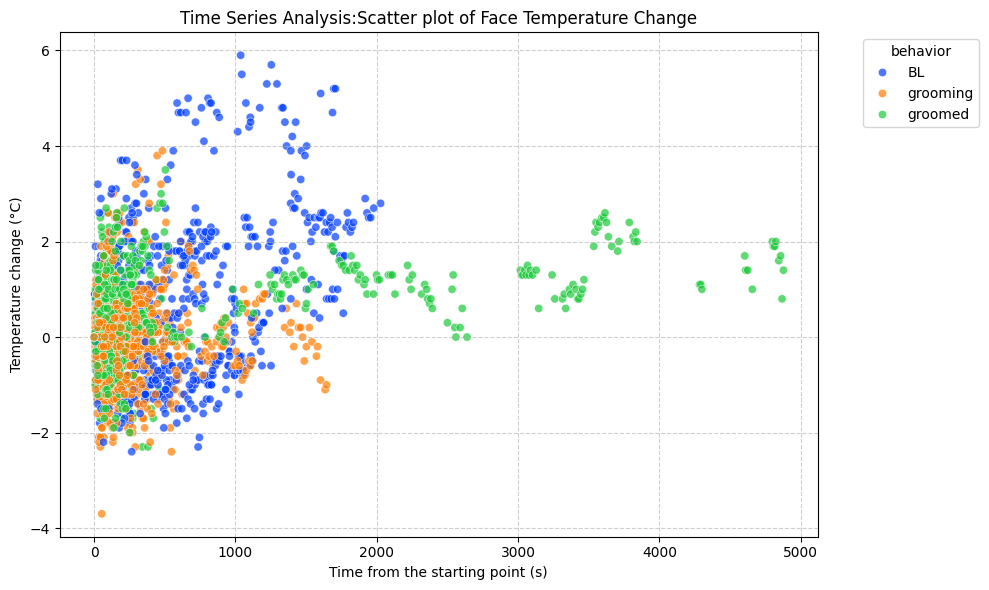

In [18]:
# 1. delta_face のプロット
self.plot_behavior_scatter(cleaned_delta_df, y_column='delta_face')

In [19]:
# 条件に合致する行を抽出
# ※ is_role_swappedがBool型（True/False）の場合は == False
# ※ もし文字列型（'False'）の場合は == 'False' としてください
# filtered_df = delta_df[(delta_df['is_role_swapped'] == False) & (delta_df['behavior'] == 'Sg')]
long_filtered_df = cleaned_delta_df[cleaned_delta_df['delta_time'] > 2500]

# 行数も確認したい場合
print(f"\n該当件数: {len(long_filtered_df)}件")


該当件数: 65件


2500秒以上の持続時間を持つplotは`sample_id == 255`のみ

In [20]:
print(long_filtered_df[['datetime', 'sampling_id', 'delta_time']])

                datetime  sampling_id  delta_time
2703 2025-07-04 07:50:48          255      2533.0
2704 2025-07-04 07:50:56          255      2541.0
2705 2025-07-04 07:51:08          255      2553.0
2706 2025-07-04 07:51:15          255      2560.0
2707 2025-07-04 07:51:45          255      2590.0
...                  ...          ...         ...
2763 2025-07-04 08:28:59          255      4824.0
2764 2025-07-04 08:29:20          255      4845.0
2765 2025-07-04 08:29:33          255      4858.0
2766 2025-07-04 08:29:43          255      4868.0
2767 2025-07-04 08:29:53          255      4878.0

[65 rows x 3 columns]


In [21]:
id_255_df = cleaned_delta_df[cleaned_delta_df['sampling_id'] == 255]
print(id_255_df[['datetime', 'sampling_id', 'delta_time', 'behavior']])

                datetime  sampling_id  delta_time behavior
2602 2025-07-04 07:08:35          255         0.0  groomed
2603 2025-07-04 07:08:46          255        11.0  groomed
2604 2025-07-04 07:08:56          255        21.0  groomed
2605 2025-07-04 07:09:05          255        30.0  groomed
2606 2025-07-04 07:09:14          255        39.0  groomed
...                  ...          ...         ...      ...
2763 2025-07-04 08:28:59          255      4824.0  groomed
2764 2025-07-04 08:29:20          255      4845.0  groomed
2765 2025-07-04 08:29:33          255      4858.0  groomed
2766 2025-07-04 08:29:43          255      4868.0  groomed
2767 2025-07-04 08:29:53          255      4878.0  groomed

[166 rows x 4 columns]


2700秒付近と3800秒付近でそれぞれ7分ほどのジャンプがある <br>
-> noiseとみなして除去

In [22]:
# delta_time が 2700 未満の行だけを抽出して delta_df に代入
timelong_filtered_delta_df = cleaned_delta_df[cleaned_delta_df['delta_time'] < 2700].copy()

# 除外後の最大値を確認（2700未満になっているか）
print(f"除外後の最大経過時間: {timelong_filtered_delta_df['delta_time'].max()} 秒")
# 行数の変化を確認
print(f"除外前の行数: {len(cleaned_delta_df)}")
print(f"除外後の行数: {len(timelong_filtered_delta_df)}")

除外後の最大経過時間: 2639.0 秒
除外前の行数: 3040
除外後の行数: 2982


### 日陰日向切り替わりsampleの除去

温度上昇がとても大きかったサンプルの特定

In [23]:
high_delta_nose_bl_df = \
    timelong_filtered_delta_df[(timelong_filtered_delta_df['delta_nose'] > 6.0) & (timelong_filtered_delta_df['behavior'] == 'BL')]
print(high_delta_nose_bl_df[['datetime', 'sampling_id', 'delta_nose', 'shade']])

               datetime  sampling_id  delta_nose shade
210 2025-05-11 10:31:40           16         6.3    no
249 2025-05-14 08:53:39           19         6.5    no
250 2025-05-14 08:53:57           19         7.6    no
251 2025-05-14 08:54:24           19         8.6    no
252 2025-05-14 08:54:34           19         8.5    no
253 2025-05-14 08:54:50           19         8.2    no
254 2025-05-14 08:55:27           19         8.3    no
255 2025-05-14 08:55:42           19         8.9    no
256 2025-05-14 08:56:34           19         8.4    no
257 2025-05-14 08:57:16           19         8.5    no
258 2025-05-14 08:57:34           19         7.6    no
259 2025-05-14 08:58:03           19         8.9    no
260 2025-05-14 08:58:15           19         8.6    no
261 2025-05-14 08:58:24           19         8.9    no
262 2025-05-14 08:58:45           19         7.8    no
263 2025-05-14 08:59:05           19         8.4    no
264 2025-05-14 08:59:22           19         8.3    no
265 2025-0

shadeとの関係性

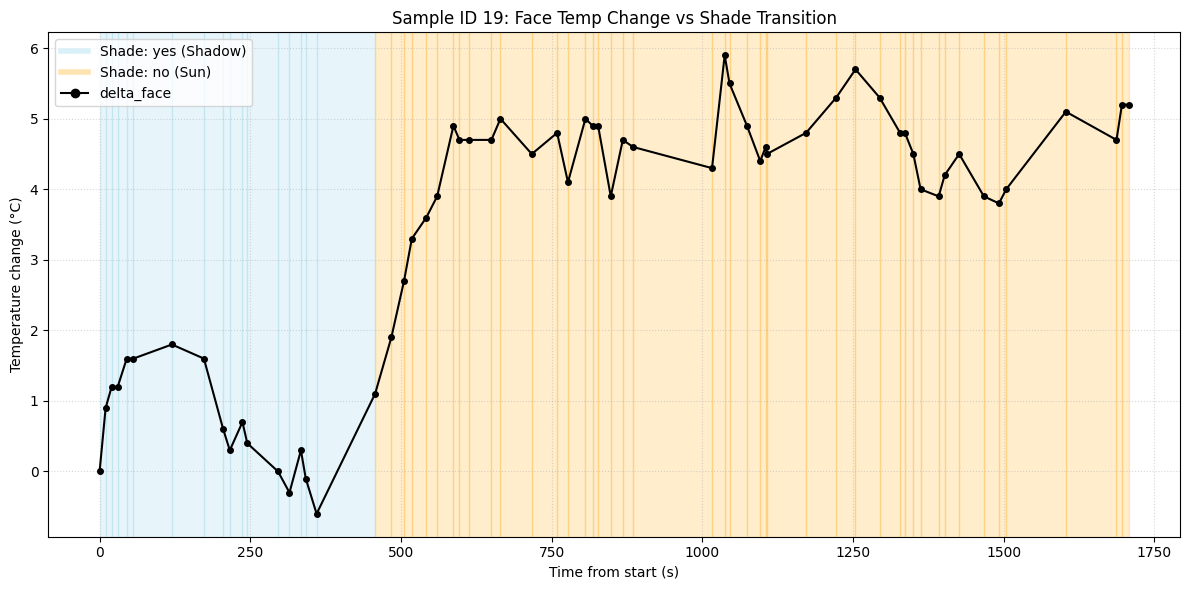

In [24]:
self.plot_sample_with_shade_transition(
    timelong_filtered_delta_df, target_id=19, y_column='delta_face'
)

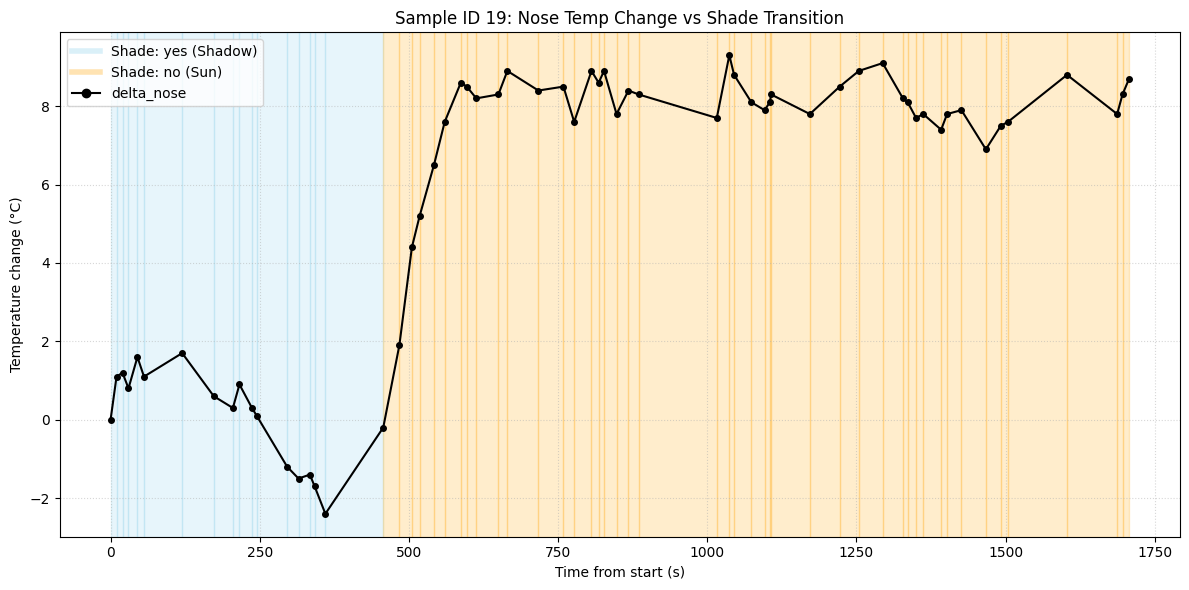

In [25]:
self.plot_sample_with_shade_transition(
    timelong_filtered_delta_df, target_id=19, y_column='delta_nose'
)

もとのdfの確認

In [26]:
self.print_sample_counts(timelong_filtered_delta_df)

========== サンプル数集計 ==========
有効な総サンプル数: 284
------------------------------------
各behaviorごとのサンプル数:
  - BL: 53
  - groomed: 108
  - grooming: 123


サンプルごとに主要なshadeを抽出して列に格納
- `yes`：90%以上日陰
- `no`：90%以上日向
- `mixed`：それ以外

In [27]:
shade_assigned_delta_df = self.assign_shade_condition(
    timelong_filtered_delta_df, threshold=0.90
)

`mixed`のsampleを除去

In [28]:
delta_df = self.filter_by_shade_consistency(
    shade_assigned_delta_df
)

self.print_sample_counts(delta_df)

========== サンプル数集計 ==========
有効な総サンプル数: 267
------------------------------------
各behaviorごとのサンプル数:
  - BL: 43
  - groomed: 105
  - grooming: 119


### 日陰日向で温度変化に有意差があるか

線形混合モデル

$$y_{it} = (\beta_0 + u_{i0}) + \beta_1 x_{i, \text{time}} + \beta_2 x_{i, \text{shade}} + \beta_3 (x_{i, \text{time}} \times x_{i, \text{shade}}) + \epsilon_{it}$$

##### 変数およびパラメータの説明

| 記号 | 名称 | 本解析における具体的な意味 |
| --- | --- | --- |
| $$y_{it}$$ | 目的変数 | 個体  の時刻  における温度変化量（`delta_nose` または `delta_face`）。 |
| $$\beta_{0}$$ | 固定切片 | 集団全体の平均的な初期値。開始時に 0 となるよう正規化されている場合、理論上は 0 に近くなります。 |
| $$u_{i0}$$ | **ランダム切片** | **個体  固有のランダム効果。** 各サンプリング個体ごとの「温度の上がりやすさ・下がりやすさ」の個体差（ベースラインのズレ）を表します。 |
| $$\beta_1$$ | 時間の主効果 | 経過時間に伴う温度変化の平均的な傾き（変化率）。 |
| $$x_{i, \text{time}}$$ | 説明変数（時間） | 計測開始時からの経過時間（`delta_time`）。 |
| $$\beta_2$$ | 環境の主効果 | 環境（日陰/日向）の違いによる温度のベースラインの差。 |
| $$x_{i, shade}$$ | 説明変数（環境） | 環境条件を示すダミー変数（例：日向=`0`, 日陰=`1`）。 |
| $$\beta_3$$ | **交互作用項** | **本解析の最重要指標。** 環境によって「時間の経過に伴う温度変化の傾き」がどれだけ異なるかを示します。 |
| $$\epsilon_{it}$$ | 残差 | モデルで説明しきれない測定ごとのランダムな誤差。 |

---

##### 数式の構造的ポイント

* **固定効果** ($$\beta$$): 全サンプルに共通する「一般的な傾向」を推定します。特に  が有意である場合、「日陰か日向かによって温度の変化スピードが統計的に異なる」と結論付けられます。
* **変量効果** ($$u_{i0}$$): 今回の解析結果で `Group Var` が `0.580` と算出された通り、個体  ごとの独自の変動をモデルに組み込んでいます。これにより、個体差によるノイズを分離し、より正確に環境の影響（）を検定することが可能になっています。


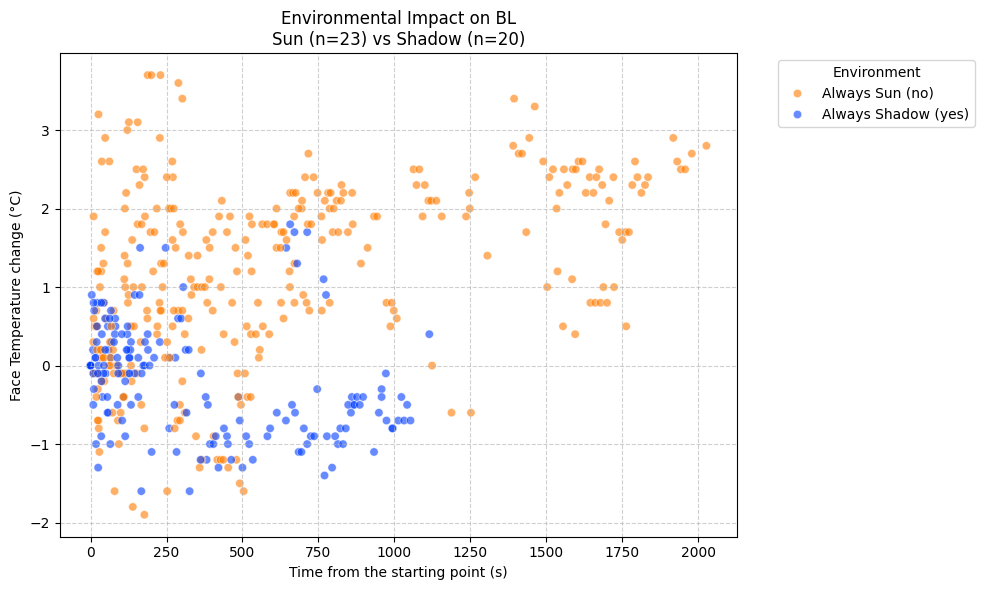

In [29]:
self.plot_behavior_shade_comparison(
    delta_df, target_behavior='BL', y_column='delta_face'
)

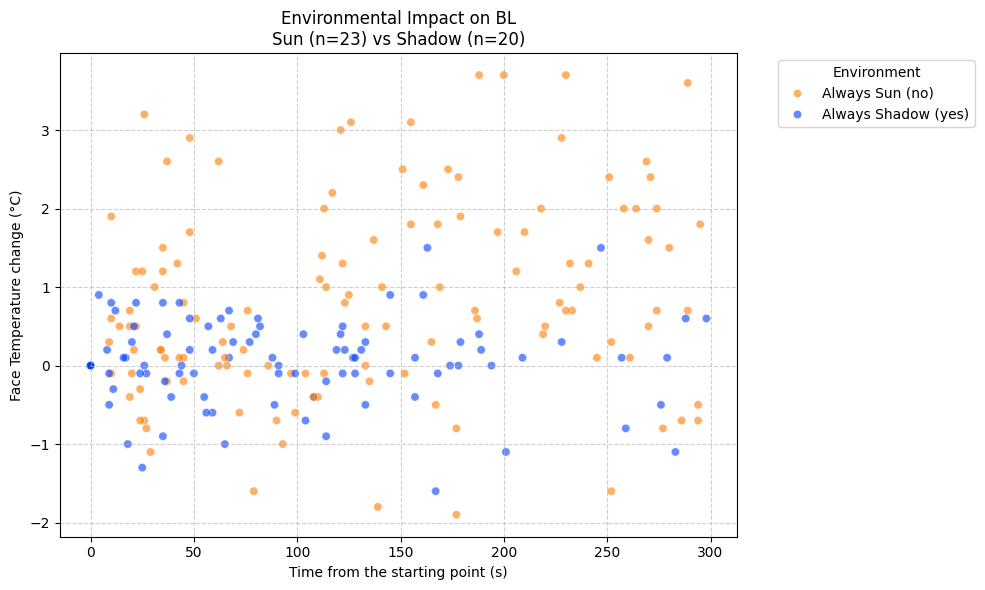

In [30]:
self.plot_behavior_shade_comparison(
    delta_df[delta_df['delta_time'] < 300], target_behavior='BL', y_column='delta_face'
)

In [31]:
face_shade_result, face_shade_model = self.test_environmental_impact_first_300s(
    delta_df, y_column='delta_face', limit_time=300
)


========== Mixed-Effects Model Analysis (delta_face, 0-300s) ==========
                   Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       delta_face
No. Observations:         1978          Method:                   REML      
No. Groups:               267           Scale:                    0.2412    
Min. group size:          1             Log-Likelihood:           -1689.6129
Max. group size:          25            Converged:                Yes       
Mean group size:          7.4                                               
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          0.002    0.052  0.041 0.967 -0.101  0.105
shade_condition[T.yes]            -0.019    0.076 -0.244 0.807 -0.167  0.130
delta_time             

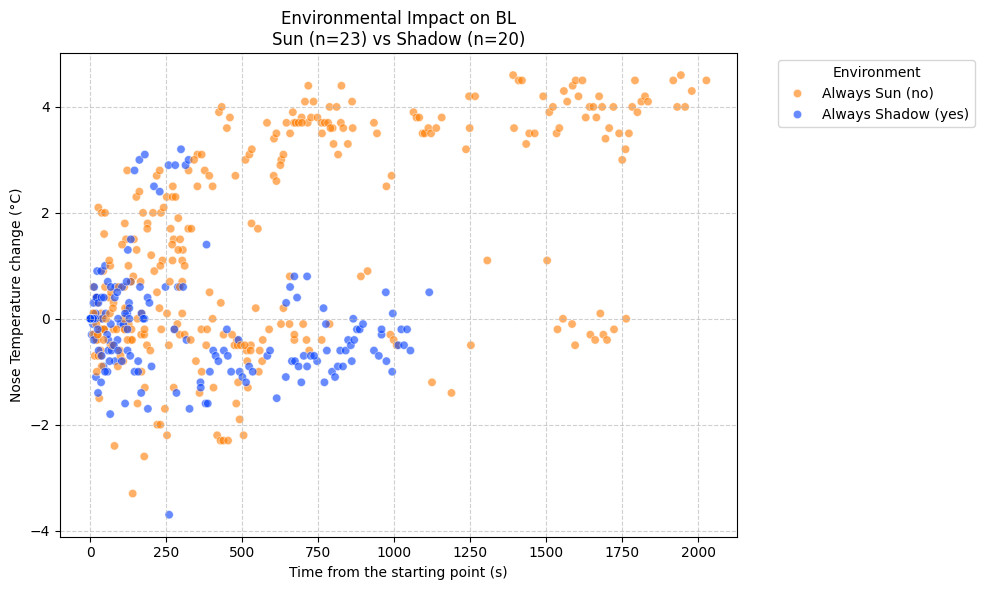

In [32]:
self.plot_behavior_shade_comparison(
    delta_df, target_behavior='BL', y_column='delta_nose'
)

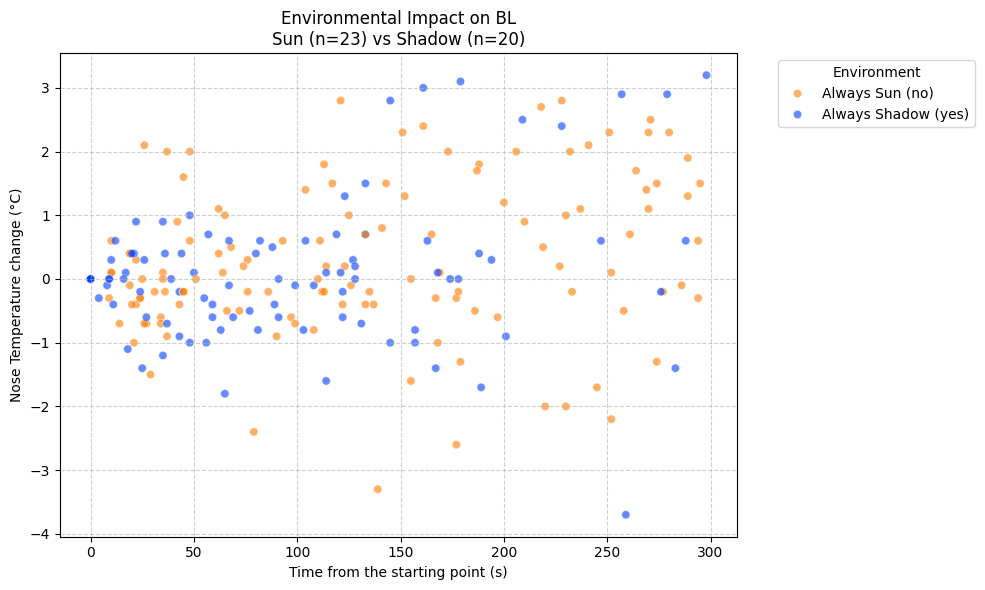

In [33]:
self.plot_behavior_shade_comparison(
    delta_df[delta_df['delta_time'] < 300], target_behavior='BL', y_column='delta_nose'
)

In [34]:
nose_shade_result, nose_shade_model = self.test_environmental_impact_first_300s(
    delta_df, y_column='delta_nose', limit_time=300
)



========== Mixed-Effects Model Analysis (delta_nose, 0-300s) ==========
                   Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       delta_nose
No. Observations:         1978          Method:                   REML      
No. Groups:               267           Scale:                    0.4296    
Min. group size:          1             Log-Likelihood:           -2271.7178
Max. group size:          25            Converged:                Yes       
Mean group size:          7.4                                               
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          0.009    0.073  0.127 0.899 -0.134  0.152
shade_condition[T.yes]            -0.052    0.106 -0.496 0.620 -0.259  0.155
delta_time             

## 温度変化散布図

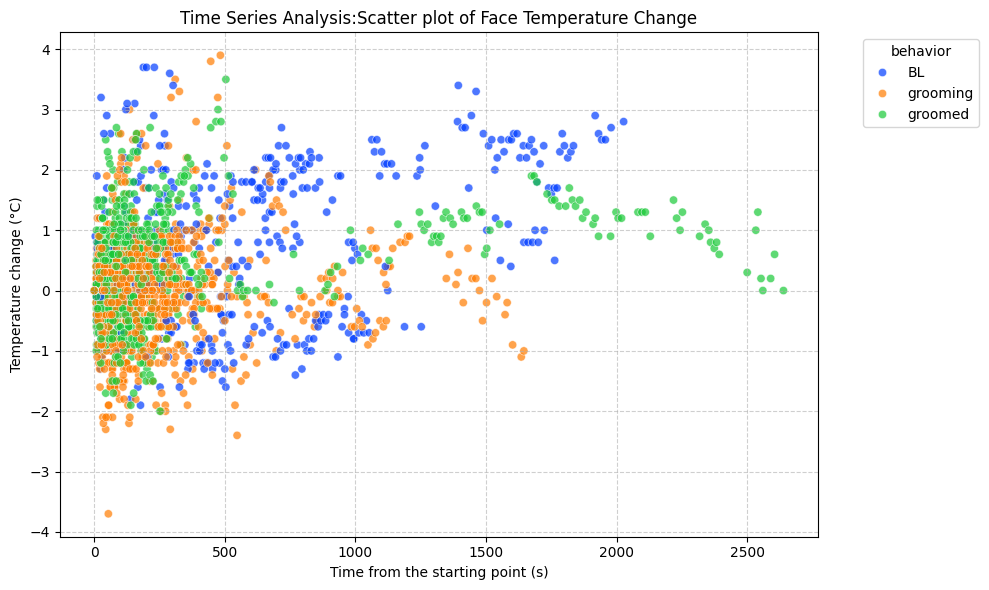

In [35]:
# 1. delta_face のプロット
self.plot_behavior_scatter(delta_df, y_column='delta_face')

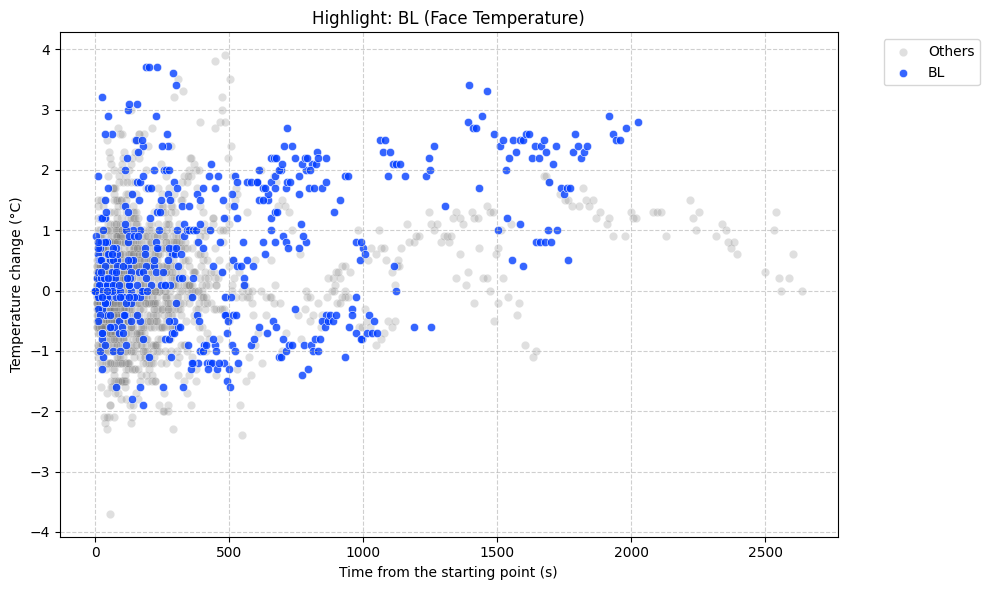

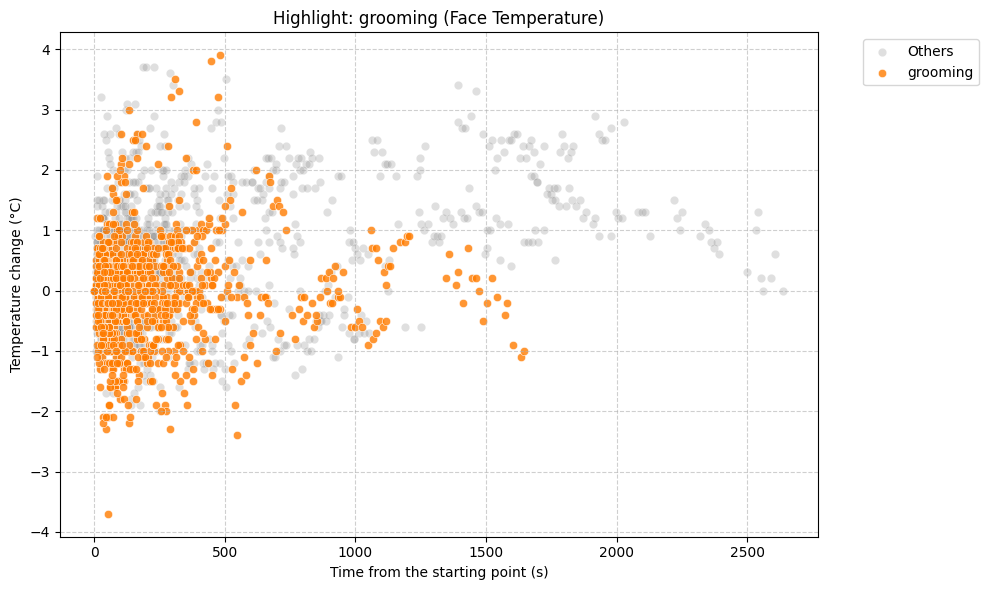

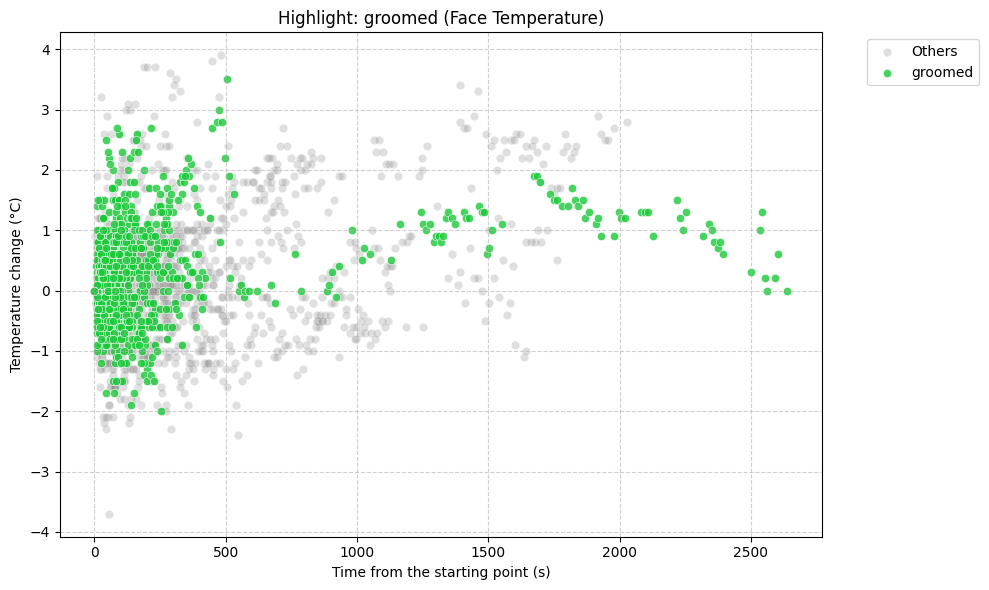

In [36]:
for behavior in delta_df['behavior'].unique():
    self.plot_highlight_behavior(delta_df, target_behavior=behavior, y_column='delta_face')

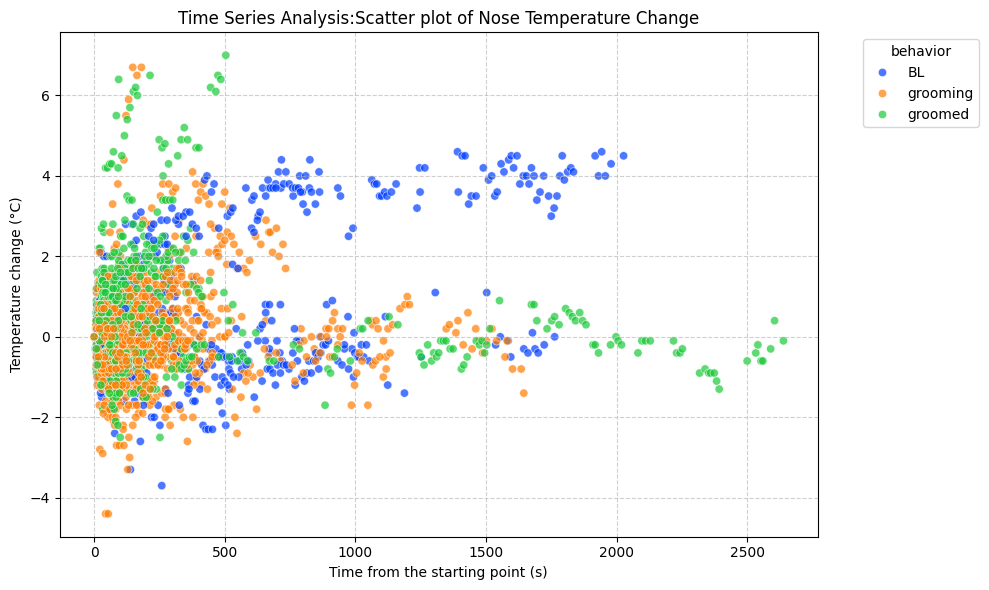

In [37]:
# 2. delta_nose のプロット
self.plot_behavior_scatter(delta_df, y_column='delta_nose')

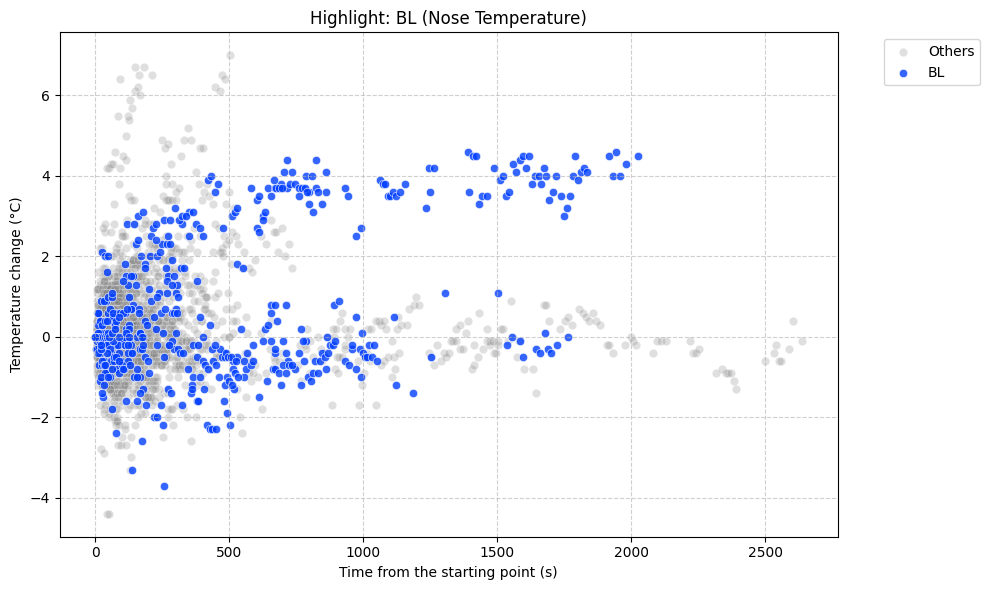

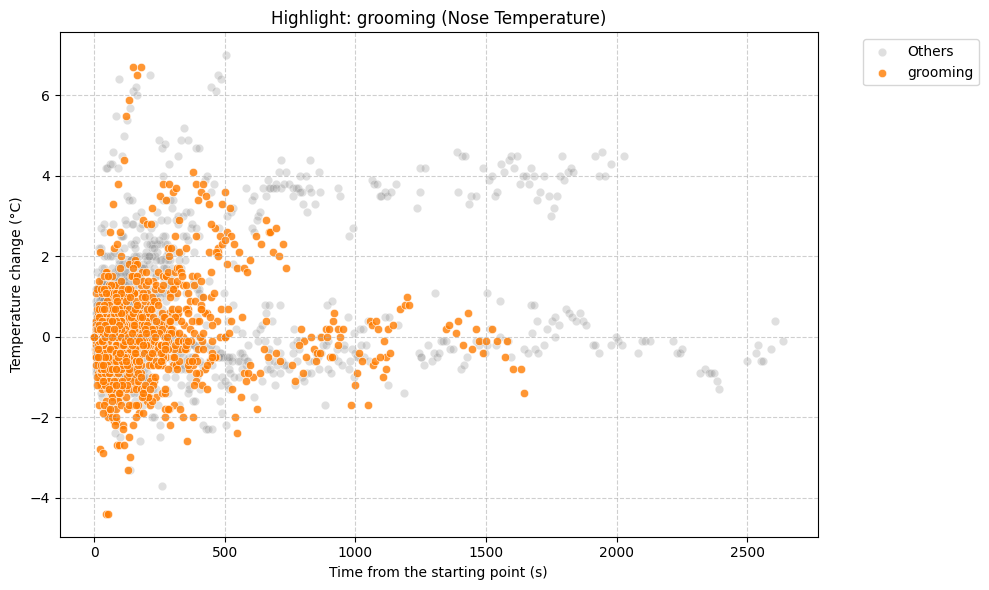

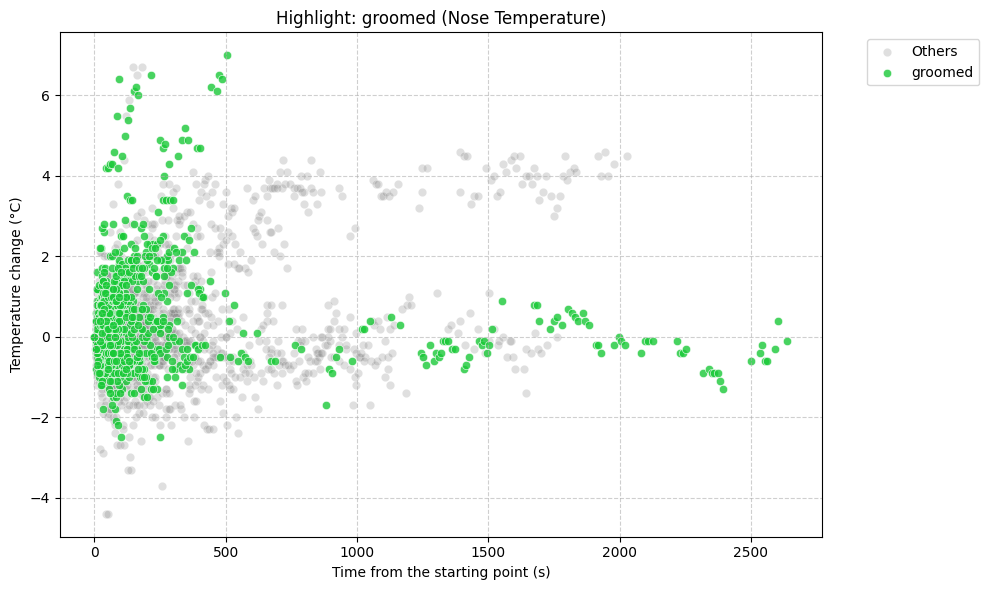

In [38]:
for behavior in delta_df['behavior'].unique():
    self.plot_highlight_behavior(delta_df, target_behavior=behavior, y_column='delta_nose')

### dataの保存

#### dfの保存

In [39]:
path = project_root / "data" / "preprocessed_data" / "temperature_delta_df.parquet"

save_to_parquet(delta_df, path)

--- 保存完了 ---
'C:\Users\yyu33\Downloads\Monkey_Aggression\data\preprocessed_data\temperature_delta_df.parquet' として保存されました。ファイルサイズ: 64.79 KB


dfのcsvでの保存

In [40]:
import pandas as pd
import os

def save_to_csv(df: pd.DataFrame, filename: str):
    """
    DataFrameをCSVファイルとして特定のディレクトリに保存します。
    """
    # 保存先のディレクトリパス
    save_dir = r"C:\Users\yyu33\Downloads\Monkey_Aggression\data\preprocessed_data"
    
    # ディレクトリが存在しない場合は作成
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"ディレクトリを作成しました: {save_dir}")
    
    # フルパスの構築
    full_path = os.path.join(save_dir, filename)
    
    # CSVとして保存（インデックスを含めるかどうかは用途に合わせて index=False で調整してください）
    delta_df.to_csv(full_path, index=False, encoding='utf-8-sig')
    
    print(f"--- CSV保存完了 ---")
    print(f"Path: {full_path}")
    print(f"ファイルサイズ: {os.path.getsize(full_path) / 1024:.2f} KB")

In [43]:
save_to_csv(delta_df, 'delta_df.csv')

--- CSV保存完了 ---
Path: C:\Users\yyu33\Downloads\Monkey_Aggression\data\preprocessed_data\delta_df.csv
ファイルサイズ: 277.96 KB


#### modelの保存

BFのdelta_noseのmodelの保存

In [41]:
path = project_root / "data" / "preprocessed_data" / "delta_nose_shade.parquet"

save_model(nose_shade_model, path)

--- モデル保存完了 ---
'C:\Users\yyu33\Downloads\Monkey_Aggression\data\preprocessed_data\delta_nose_shade.parquet' として保存されました。


BFのdelta_faceのmodelの保存

In [42]:
path = project_root / "data" / "preprocessed_data" / "delta_face_shade.parquet"

save_model(face_shade_model, path)

--- モデル保存完了 ---
'C:\Users\yyu33\Downloads\Monkey_Aggression\data\preprocessed_data\delta_face_shade.parquet' として保存されました。
